In [1]:
import pandas as pd
import os
os.chdir("../..")

In [2]:
from subspace_model.experiments.experiment import psuu


2024-04-09 19:02:30 - subspace-digital-twin - INFO
------------subspace-digital-twin------------


In [4]:
sim_df = psuu(SIMULATION_DAYS=3*365, TIMESTEP_IN_DAYS=7, SAMPLES=1, N_SWEEP_SAMPLES=160,   SWEEPS_PER_PROCESS=10, PROCESSES=8, PARALLELIZE=True, USE_JOBLIB=True)


2024-04-09 19:02:51 - subspace-digital-twin - INFO
------------subspace-digital-twin------------

2024-04-09 19:02:51 - subspace-digital-twin - INFO
------------subspace-digital-twin------------

2024-04-09 19:02:51 - subspace-digital-twin - INFO
------------subspace-digital-twin------------

2024-04-09 19:02:51 - subspace-digital-twin - INFO
------------subspace-digital-twin------------
Initializing configurations:   0%|          | 0/10 [00:00<?, ?it/s]
2024-04-09 19:02:51 - subspace-digital-twin - INFO
------------subspace-digital-twin------------

2024-04-09 19:02:51 - subspace-digital-twin - INFO
------------subspace-digital-twin------------

2024-04-09 19:02:51 - subspace-digital-twin - INFO
------------subspace-digital-twin------------
Initializing configurations:  50%|█████     | 5/10 [00:00<00:00, 36.70it/s]

3, 2024-04-09 19:02:51.282719

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 157, 46, 10, 77)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (157, 46, 10, 77)


Initializing configurations: 100%|██████████| 10/10 [00:00<00:00, 27.50it/s]


Execution Method: single_proc_exec
Execution Mode: single_threaded
0, 2024-04-09 19:02:53.077830

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 157, 46, 10, 77)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (157, 46, 10, 77)
1, 2024-04-09 19:02:53.238128

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 157, 46, 10, 77)
     Simulation 0: (Timesteps, Params, Run

Initializing configurations:   0%|          | 0/10 [00:00<?, ?it/s].94it/s]

4, 2024-04-09 19:02:53.280578

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 157, 46, 10, 77)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (157, 46, 10, 77)
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 157, 46, 10, 77)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (157, 46, 10, 77)
6, 2024-04-09 19:02:53.319734

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simu

Initializing configurations: 100%|██████████| 10/10 [00:00<00:00, 41.88it/s]


Execution Method: single_proc_exec
Execution Mode: single_threaded
Execution Method: single_proc_exec
Execution Mode: single_threaded
Execution Method: single_proc_exec
Execution Mode: single_threaded
Execution Method: single_proc_exec
Execution Mode: single_threaded
Execution Method: single_proc_exec
Execution Mode: single_threaded


Flattening results:   0%|          | 7/23560 [00:00<16:52, 23.26it/s]

Total execution time: 69.82s


Flattening results:   0%|          | 10/23560 [00:00<17:51, 21.97it/s]


Total execution time: 68.29s


Flattening results:   0%|          | 10/23560 [00:00<14:17, 27.46it/s]


8, 2024-04-09 19:04:02.266145

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 157, 46, 10, 77)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (157, 46, 10, 77)
Total execution time: 68.98s
Total execution time: 69.06s


Flattening results:   0%|          | 0/23560 [00:00<?, ?it/s]?it/s]

Execution Method: single_proc_exec
Execution Mode: single_threaded
9, 2024-04-09 19:04:02.500147

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 157, 46, 10, 77)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (157, 46, 10, 77)


Initializing configurations: 100%|██████████| 10/10 [00:00<00:00, 38.79it/s]


Execution Method: single_proc_exec
Execution Mode: single_threaded
Total execution time: 69.66s


Flattening results:   0%|          | 0/23560 [00:00<?, ?it/s]

Total execution time: 69.84s
Total execution time: 70.03s


Flattening results:   0%|          | 10/23560 [00:00<15:04, 26.04it/s]


Total execution time: 70.41s
10, 2024-04-09 19:04:03.877188

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 157, 46, 10, 77)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (157, 46, 10, 77)


Initializing configurations:  40%|████      | 4/10 [00:00<00:00, 27.02it/s]

11, 2024-04-09 19:04:03.896406

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 157, 46, 10, 77)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (157, 46, 10, 77)


Initializing configurations: 100%|██████████| 10/10 [00:00<00:00, 37.09it/s]


Execution Method: single_proc_exec
Execution Mode: single_threaded
Execution Method: single_proc_exec
Execution Mode: single_threaded


Initializing configurations: 100%|██████████| 10/10 [00:00<00:00, 53.28it/s]


12, 2024-04-09 19:04:04.558860

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 157, 46, 10, 77)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (157, 46, 10, 77)
13, 2024-04-09 19:04:04.676033

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 157, 46, 10, 77)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (157, 46, 10, 77)
14, 2024-04-09 19:04:04.683972

Initializing configurations:   0%|          | 0/10 [00:00<?, ?it/s]

Execution Method: single_proc_exec
Execution Mode: single_threaded
Execution Method: single_proc_exec
Execution Mode: single_threaded
15, 2024-04-09 19:04:04.962803

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 157, 46, 10, 77)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (157, 46, 10, 77)


Initializing configurations: 100%|██████████| 10/10 [00:00<00:00, 48.67it/s]


Execution Method: single_proc_exec
Execution Mode: single_threaded


Flattening results:   0%|          | 10/23560 [00:00<10:29, 37.42it/s]


Total execution time: 66.75s
Total execution time: 67.04s


Flattening results:   0%|          | 10/23560 [00:00<07:27, 52.64it/s]


Total execution time: 66.01s
Total execution time: 66.71s


Flattening results:   0%|          | 10/23560 [00:00<07:19, 53.56it/s]


Total execution time: 67.23s


Flattening results:   0%|          | 10/23560 [00:00<07:03, 55.54it/s]


Total execution time: 66.96s
Total execution time: 67.02s


Flattening results:   0%|          | 10/23560 [00:00<06:18, 62.27it/s]


Total execution time: 67.13s


In [5]:
i = 0
sim_df[f'component_{i+1}_initial_period_start'] = sim_df.reference_subsidy_components.map(lambda x: x[i].initial_period_start)
sim_df[f'component_{i+1}_initial_period_duration'] = sim_df.reference_subsidy_components.map(lambda x: x[i].initial_period_duration)
sim_df[f'component_{i+1}_max_cumulative_subsidy'] = sim_df.reference_subsidy_components.map(lambda x: x[i].max_cumulative_subsidy)
sim_df[f'component_{i+1}_max_reference_subsidy'] = sim_df.reference_subsidy_components.map(lambda x: x[i].max_reference_subsidy)

i = 1
sim_df[f'component_{i+1}_initial_period_start'] = sim_df.reference_subsidy_components.map(lambda x: x[i].initial_period_start)
sim_df[f'component_{i+1}_initial_period_duration'] = sim_df.reference_subsidy_components.map(lambda x: x[i].initial_period_duration)
sim_df[f'component_{i+1}_max_cumulative_subsidy'] = sim_df.reference_subsidy_components.map(lambda x: x[i].max_cumulative_subsidy)
sim_df[f'component_{i+1}_max_reference_subsidy'] = sim_df.reference_subsidy_components.map(lambda x: x[i].max_reference_subsidy)



In [6]:
from subspace_model.psuu.kpis import KPI_functions
from subspace_model.params import GOVERNANCE_SURFACE

governance_surface_params = (set(GOVERNANCE_SURFACE.keys()) | {c for c in sim_df.columns if 'component' in c}) - {'reference_subsidy_components'}

trajectory_id_columns = ['simulation', 'subset', 'run']
agg_columns = trajectory_id_columns + list(governance_surface_params)

kpi_dfs = []
label_dfs = []
for kpi, (kpi_f, threshold_f) in KPI_functions.items():
    kpi_s = sim_df.groupby(agg_columns).apply(kpi_f)
    kpi_s.name = kpi
    kpi_dfs.append(kpi_s)

    label_s = kpi_s.map(lambda x: threshold_f(x, kpi_s.values))
    label_s.name = kpi
    label_dfs.append(label_s)


all_kpi_df = pd.concat(kpi_dfs, axis=1)
all_labels_df = pd.concat(label_dfs, axis=1)

In [31]:
import matplotlib.pyplot as plt # type: ignore
from sklearn.tree import plot_tree # type: ignore
from sklearn.tree import DecisionTreeClassifier # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
import seaborn as sns

def kpi_plot(label_df, kpi, drop_nan=True):
    df = label_df[kpi].reset_index()
    features = list(set(governance_surface_params) - {kpi})

    X = df.loc[:, features]
    y = df.loc[:, kpi]

    if drop_nan:
        inds = (y != None)
        X = X.loc[inds]
        y = y.loc[inds]

    model = DecisionTreeClassifier(max_depth=3)
    rf = RandomForestClassifier()
    model.fit(X, y)
    rf.fit(X, y)



    rf_df = (pd.DataFrame(list(zip(X.columns, rf.feature_importances_)),
                        columns=['features', 'importance'])
            .sort_values(by='importance', ascending=False)
            )


    fig, axes = plt.subplots(nrows=2,
                                figsize=(36, 12),
                                dpi=100,
                                gridspec_kw={'height_ratios': [3, 1]})

    (ax_dt, ax_rf) = axes[0], axes[1]
    plot_tree(model,
                rounded=True,
                proportion=True,
                fontsize=8,
                feature_names=X.columns,
                class_names=['threshold not met', 'threshold met'],
                filled=True,
                ax=ax_dt)
    ax_dt.set_title(
        f'Decision tree for KPI {kpi}, score: {model.score(X, y) :.0%}. N: {len(X) :.2e}')
    sns.barplot(data=rf_df,
                x=rf_df.features,
                y=rf_df.importance,
                ax=ax_rf,
                label='small')
    plt.setp(ax_rf.xaxis.get_majorticklabels(), rotation=45)
    ax_rf.set_title(f'Feature importance')
    plt.show()

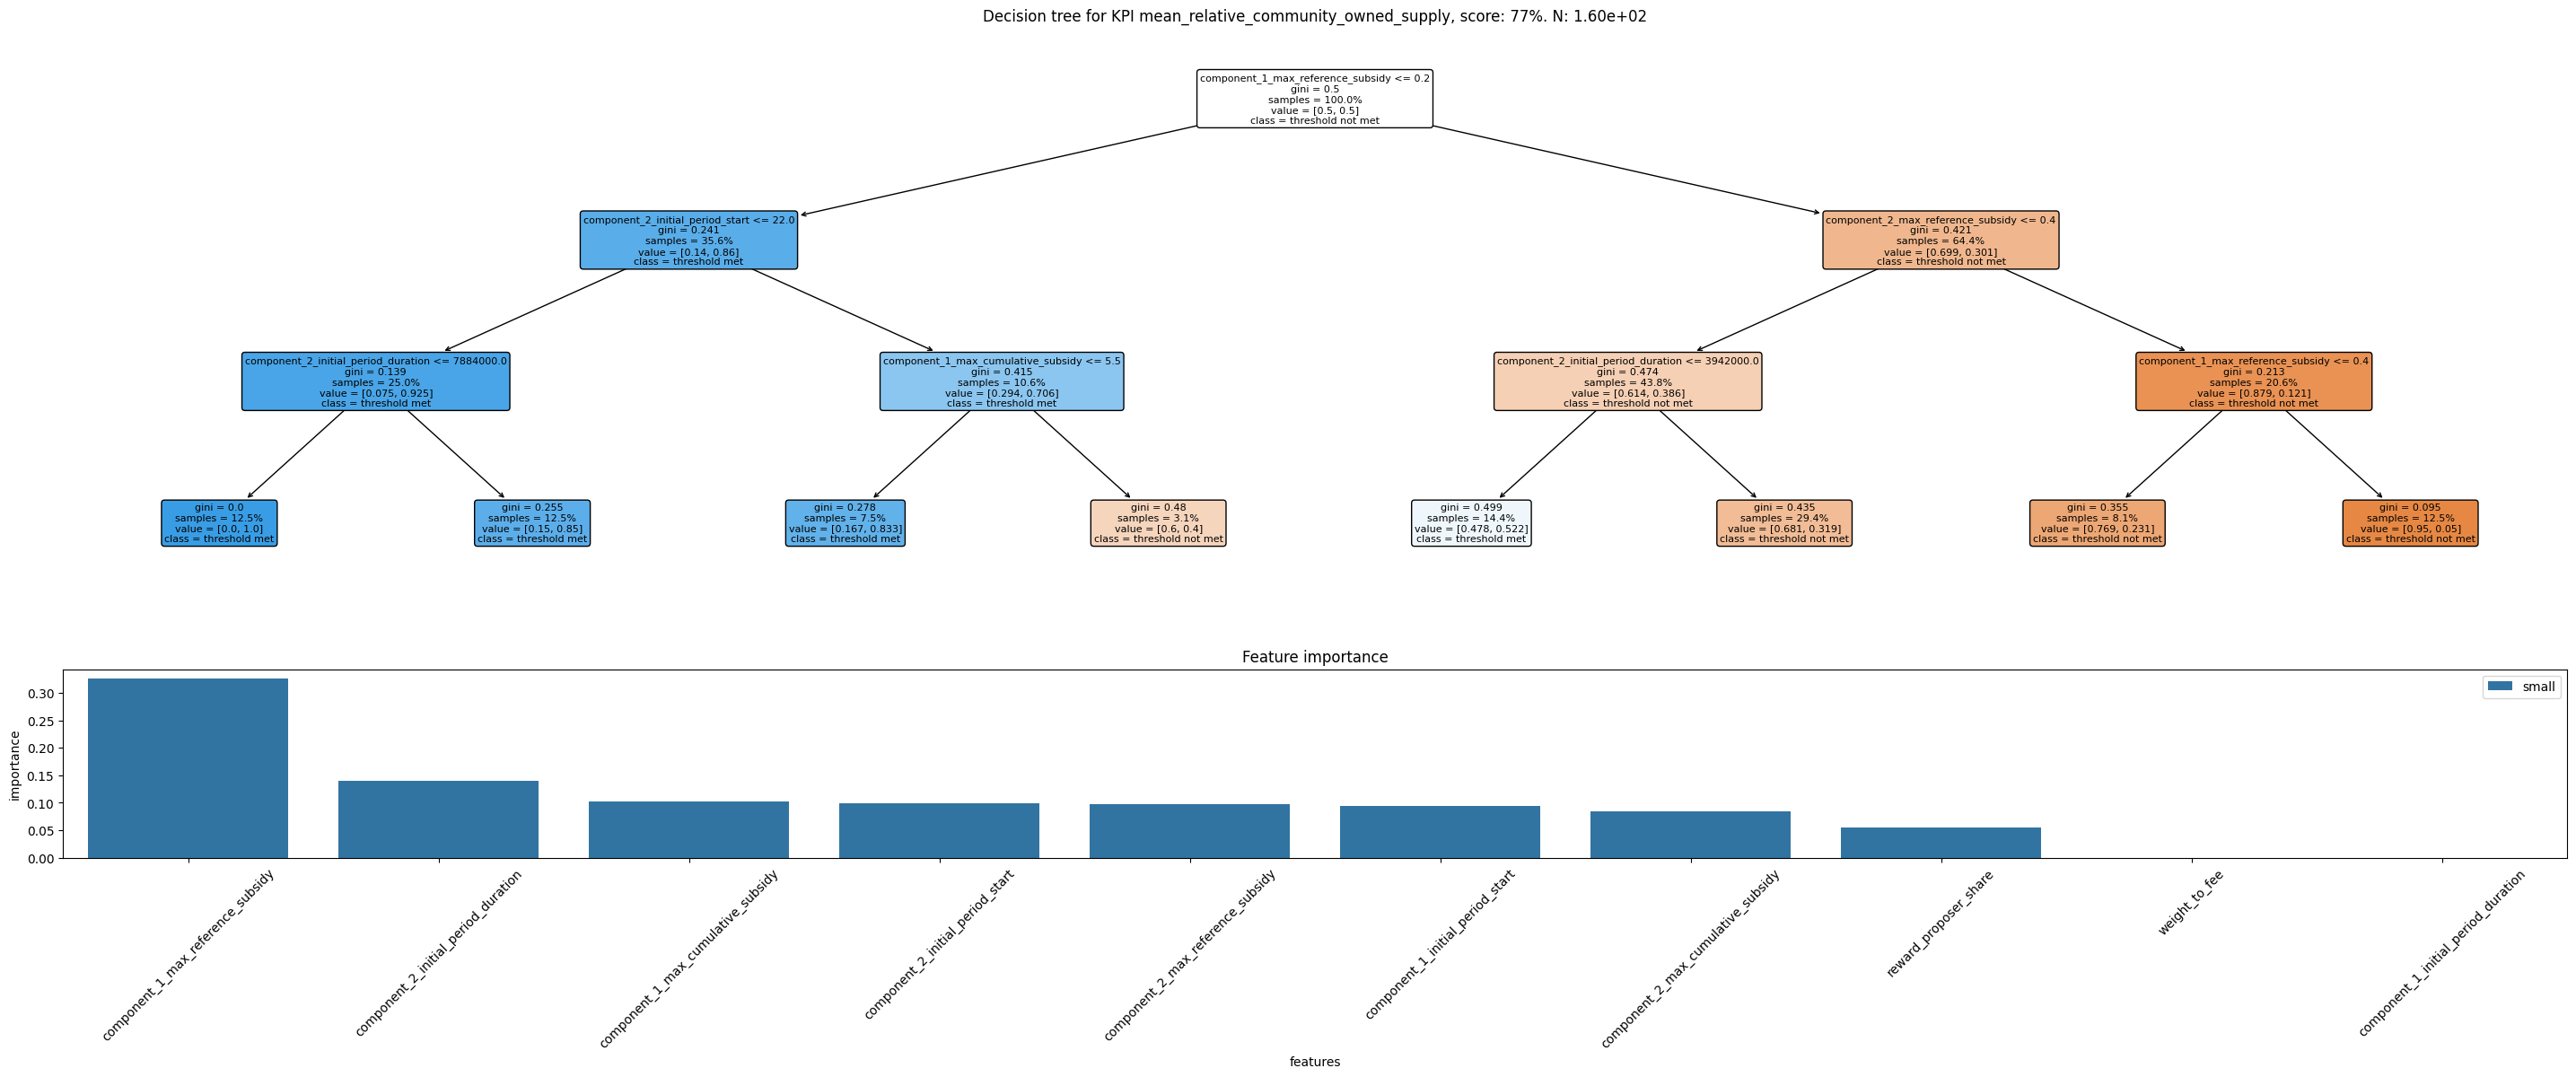

Error plotting KPI mean_farmer_subsidy_factor
Error plotting KPI mean_proposing_rewards_per_newly_pledged_space
Error plotting KPI mean_proposer_reward_minus_voter_reward
Error plotting KPI cumm_rewards_before_1yr
Error plotting KPI abs_sum_storage_fees_per_sum_compute_fees
Error plotting KPI cumm_rewards


In [32]:
for kpi in KPI_functions.keys():
    try:
        kpi_plot(all_labels_df, kpi)
    except:
        print(f"Error plotting KPI {kpi}")